<a href="https://colab.research.google.com/github/kyalan/DataScienceFactory/blob/master/20200409_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the TensorBoard notebook extension.
# %load_ext tensorboard

import os, sys
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from datetime import datetime as dt
import sklearn.metrics
import seaborn as sns

from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

print(tf.__version__)
print(tfds.__version__)

2.2.0-rc2
2.1.0


# Import data

In [23]:
(ds_train, ds_dev, ds_test), info = tfds.load('cats_vs_dogs', split=('train[:80%]', 'train[80%:90%]', 'train[90%:]')
    , shuffle_files=True, with_info=True, as_supervised=True)
print(info)
n_train, n_dev, n_test = len(list(ds_train)), len(list(ds_dev)), len(list(ds_test))
print('no. of data for train, dev, test', n_train, n_dev, n_test)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [0]:
INPUT_SHAPE = info.features['image'].shape
LABEL_NAMES = info.features['label'].names
N_LABELS = info.features['label'].num_classes

In [32]:
if INPUT_SHAPE[0:2]==(None, None):
    INPUT_SHAPE = (224, 224, 3)
    print("Input Shape is changed to {}".format(INPUT_SHAPE))

Input Shape is changed


Label: 1 - dog Image Max Value: 255, with size: (500, 306, 3)


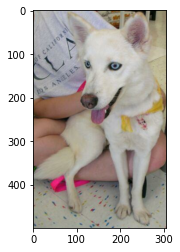

In [26]:
# check data structure
for img, label in ds_train.take(1):
    image = img.numpy().squeeze()
    label = label.numpy()

    print("Label: {} - {}".format(label, LABEL_NAMES[label]), "Image Max Value: {}, with size: {}".format(image.max(), image.shape))
    # plt.imshow(image, cmap=plt.cm.binary)
    plt.imshow(image)
    plt.show()

Label: 0 - cat Image Max Value: 255


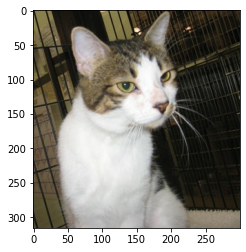

Label: 1 - dog Image Max Value: 255


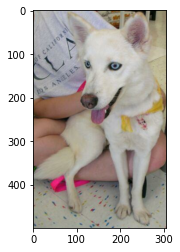

In [9]:
for i in range(N_LABELS):
    ds_temp_train = ds_train.filter(lambda img, label: label==i)
    for img, label in ds_temp_train.take(1):
        image = img.numpy().squeeze()
        label = label.numpy()

        print("Label: {} - {}".format(label, LABEL_NAMES[label]), "Image Max Value: {}".format(image.max()))
        # plt.imshow(image, cmap=plt.cm.binary)
        plt.imshow(image)
        plt.show()

# Pre-processing

In [0]:
def preprocessor(imgs, labels):
    imgs = tf.cast(imgs, tf.float32)
    imgs = tf.image.resize(imgs, INPUT_SHAPE[0:2])
    imgs /= 255.0
    return imgs, labels

In [0]:
ds_train = ds_train.map(preprocessor).batch(128)
ds_dev = ds_dev.map(preprocessor).batch(128)
ds_test = ds_test.map(preprocessor)

# Modeling

In [0]:
def getModel():
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
    from tensorflow.keras.optimizers import Adam

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=INPUT_SHAPE))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2))) 
    model.add(BatchNormalization())
    model.add(Dropout(0.2))       
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))    
    model.add(BatchNormalization())
    model.add(Dropout(0.2))        
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))    
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

In [0]:
# Tensorboards callback setting
# Clear logs prior to logging data.
# !rm -rf logs

# Create log directory
# logdir = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [0]:
%%time

model = getModel()

# %tensorboard --logdir logs
history = model.fit(ds_train, epochs=5, validation_data=ds_dev, verbose=1
                    # , callbacks=[tensorboard_callback]
                    )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
dropout_10 (Dropout)         (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 112, 112, 64)     

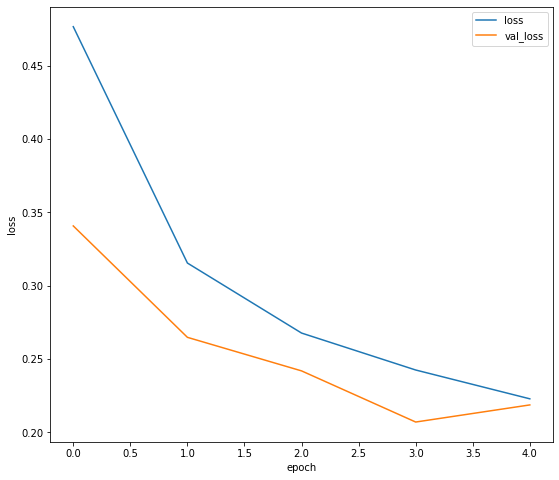

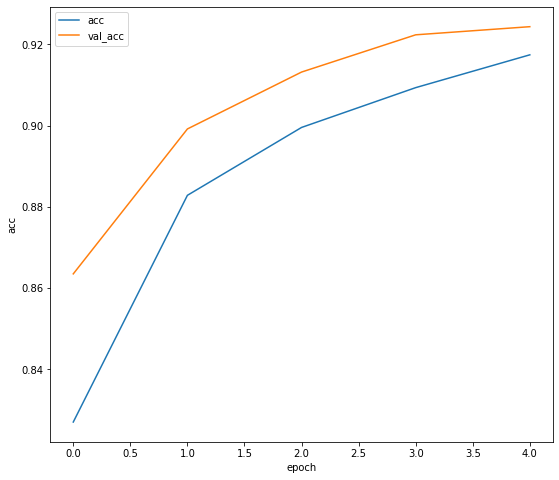

In [0]:
def plot_history(history):
    hist = history.history
    for key in ['loss', 'acc']:
        plt.figure(figsize=(9, 8))
        plt.xlabel('epoch')
        plt.ylabel(key)
        plt.plot(range(len(hist[key])), hist[key], label = key)
        plt.plot(range(len(hist['val_' + key])), hist['val_' + key], label = 'val_' + key)
        plt.legend()
    plt.show()

%matplotlib inline
plot_history(history)

# Model Evaluation

In [0]:
eval = model.evaluate(ds_test.batch(128))
print('Test data: Loss = {}, Accuracy = {}'.format(eval[0], eval[1]))
print('Right Prediction: {}, Wrong Prediction: {}'.format(eval[1]*n_test, (1.0-eval[1])*n_test))

79/79 [==============================] - 4s 53ms/step - loss: 0.2513 - acc: 0.9118
Test data: Loss = 0.25132137537002563, Accuracy = 0.9118000268936157
Right Prediction: 9118.000268936157, Wrong Prediction: 881.9997310638428


In [0]:
%%time

test_labels = [x.numpy() for x in ds_test.map(lambda _, label: label)]
test_pred = model.predict(ds_test.batch(128)).argmax(axis=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function <lambda> at 0x7fd78d1aba60>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function <lambda> at 0x7fd78d1aba60>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function <lambda> at 0x7fd78d1aba60>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 11.5 s, sys: 3.77 s, total: 15.3 s
Wall time: 8.72 s


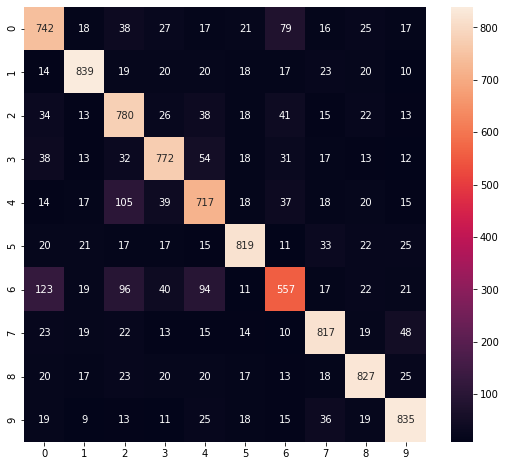

In [0]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
fig = plt.figure(figsize=(9, 8))
sns.heatmap(pd.DataFrame(cm, range(10), range(10)), annot=True, fmt='d')

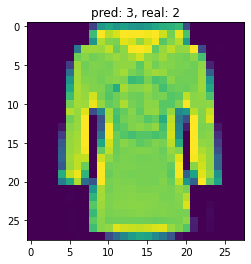

In [0]:
iimg = np.where(test_labels!=test_pred)[0][0]
for img, label in ds_test.skip(iimg).take(1):
    plt.imshow(img.numpy().squeeze())
    plt.title('pred: {}, real: {}'.format(test_pred[iimg],test_labels[iimg]))